In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from pair_selection import PairSelection
%matplotlib inline

## Part A & B: Narrow down the stock pairs universe

This notebook showcases how to select stock pairs from S&P 500 constitutents for mean-reversion pair trading.

Currently, there are 505 stocks that constitute the S&P 500 index. It would be unreasonable to consider every possible pairs as there would be $\binom{505}{2}$ pairs, which are 127,260 pairs in numbers. So to narrow down the stock pairs universe, we resort to PCA and clustering to narrow down the stock pairs universe before calculating hedge ratio for each one of them.

Although the original paper suggests using 5-minute intraday data, unfortunately, the Yahoo! Finance API did not support intra-day data download. For demonstration purposes, we used daily data starting from Jan 4th, 2016 (The first trading day of 2016) to date, which approximately amounts to 5 years' worth of data. If a stock doesn't have historical data that date back to 5 years ago, we drop the stock from the universe.

We narrow down the stock pairs universe following steps:
- Compute percentage returns of each stock.
- Standardize the returns into Z-scores.
- Perform PCA on the Z-scores.
- Clustering on the PCA representation of the percentage returns using OPTICS.
- Generate pairs within each clusters.

We can perform these steps simply by calling the function `form_pairs()`.

In [2]:
pair_selector = PairSelection()
stock_pairs = pair_selector.form_pairs()

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
No data for BF.B!
No data for BRK.B!
Ticker doesn't exist!
Ticker doesn't exist!
Stock CARR has insufficient data!
Stock CTVA has insufficient data!
Stock DOW has insufficient data!
Stock FTV has insufficient data!
Stock FOXA has insufficient data!
Stock FOX has insufficient data!
Stock HWM has insufficient data!
Stock IR has insufficient data!
Stock LW has insufficient data!
Stock LUMN has insufficient data!
Stock OTIS has insufficient data!
Stock VIAC has insufficient data!
Stock VNT has insufficient data!


The `yfinance` package output tells us only few stocks were dropped, which left us with 490 stock candidates for mean-reversion pair trading.

The PCA and OPTICS clustering successfully narrowed down the pairs candidate from 127,260 to 446.

In this demonstration, we compressed the percentage return into 8 dimensions.

After the module completed PCA and OPTICS:
- The compressed representation can be accessed via `pca_repr` attribute.
- The clustering results can be accessed via `clusterings` attribute.
- The price history can be accessed via `pricedict` attribute.

In [3]:
pair_selector.pca_repr.shape

(490, 8)

In [4]:
len(stock_pairs)

446

### PCA feature vector visualization 

The distribution of each principal component (PC) and the correlation between every PC pair can be shown as follows.

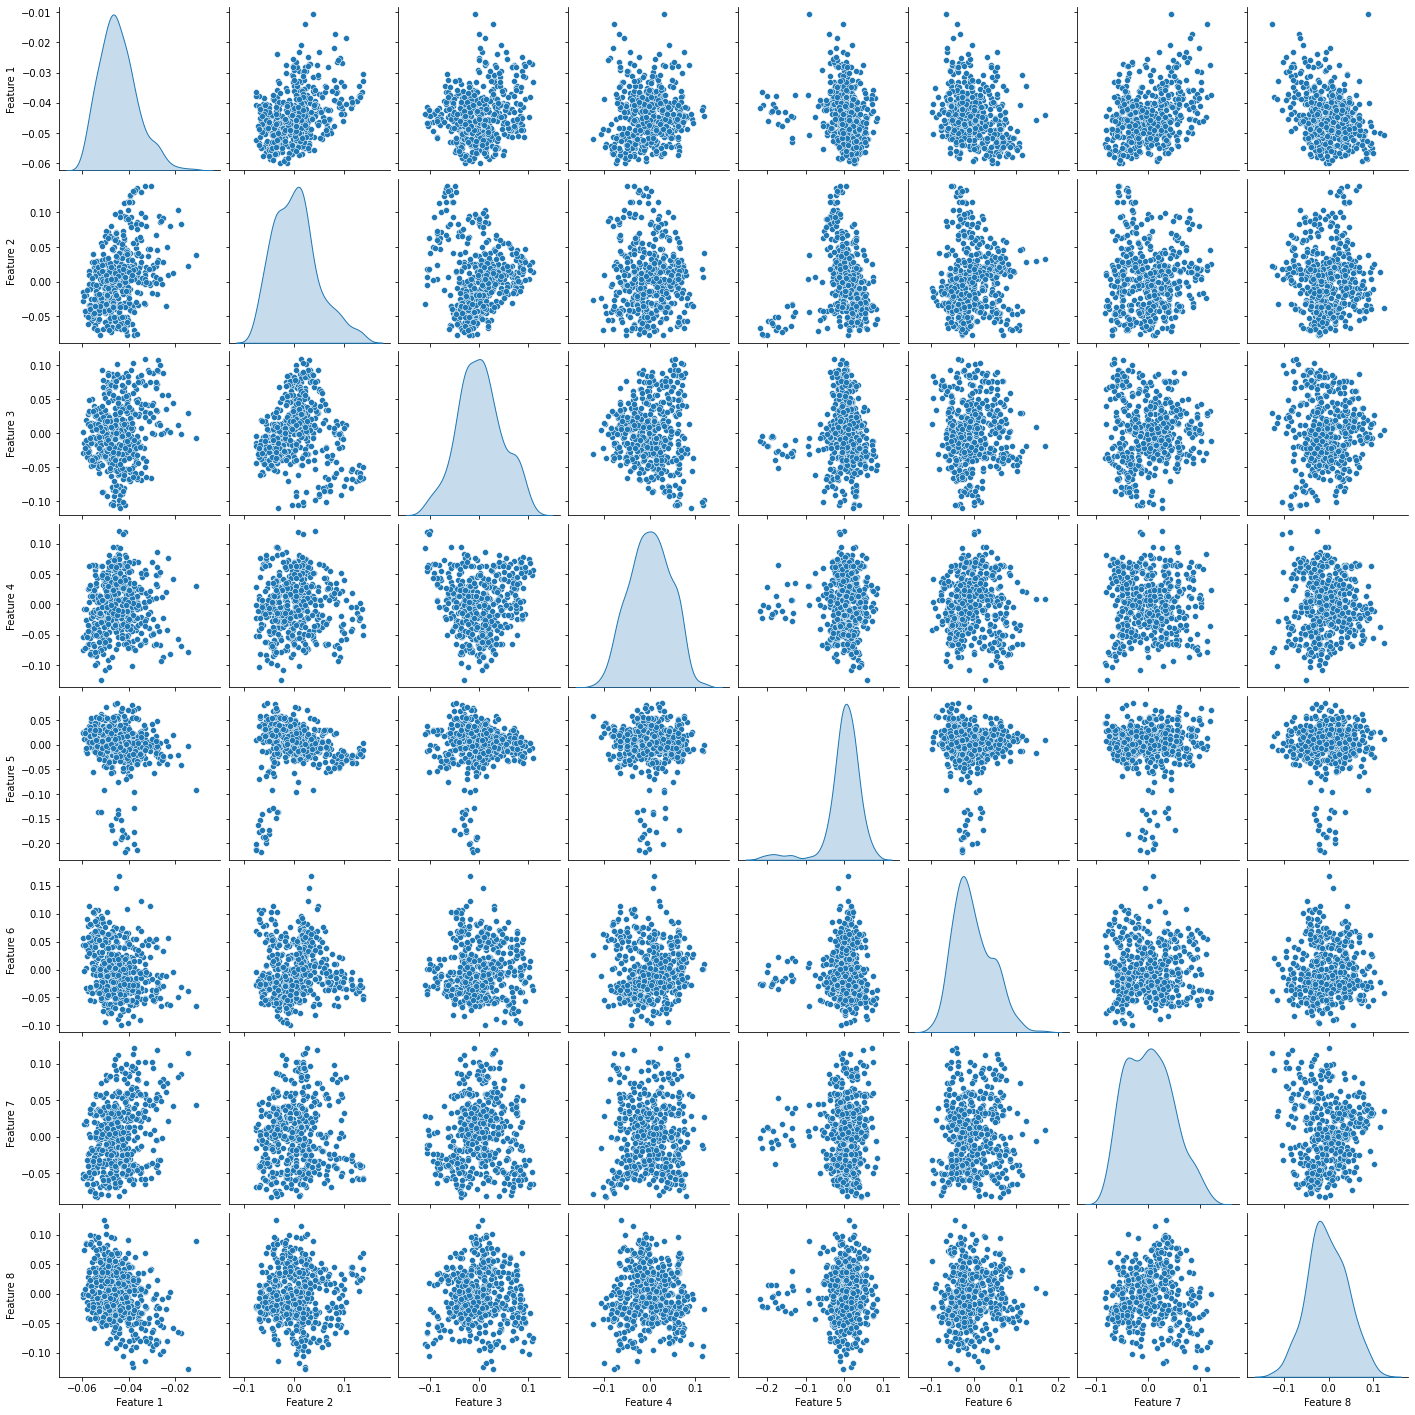

In [5]:
sns.pairplot(pair_selector.pca_repr, diag_kind='kde')

### OPTICS clustering visualization

Using T-SNE to further project this 8-dimension feature space onto a 2d plot, we show the clustering result.

In [6]:
tsne = TSNE(n_components=2)
tsne_pca = tsne.fit_transform(pair_selector.pca_repr)
tsne_pca_df = pd.DataFrame(tsne_pca)
tsne_pca_df.index = pair_selector.pca_repr.index
tsne_pca_df.columns = ['TSNE_1', 'TSNE_2']
tsne_pca_df['cluster'] = pair_selector.clusterings
tsne_pca_df['cluster'] = pd.Categorical(tsne_pca_df['cluster'])

<AxesSubplot:xlabel='TSNE_1', ylabel='TSNE_2'>

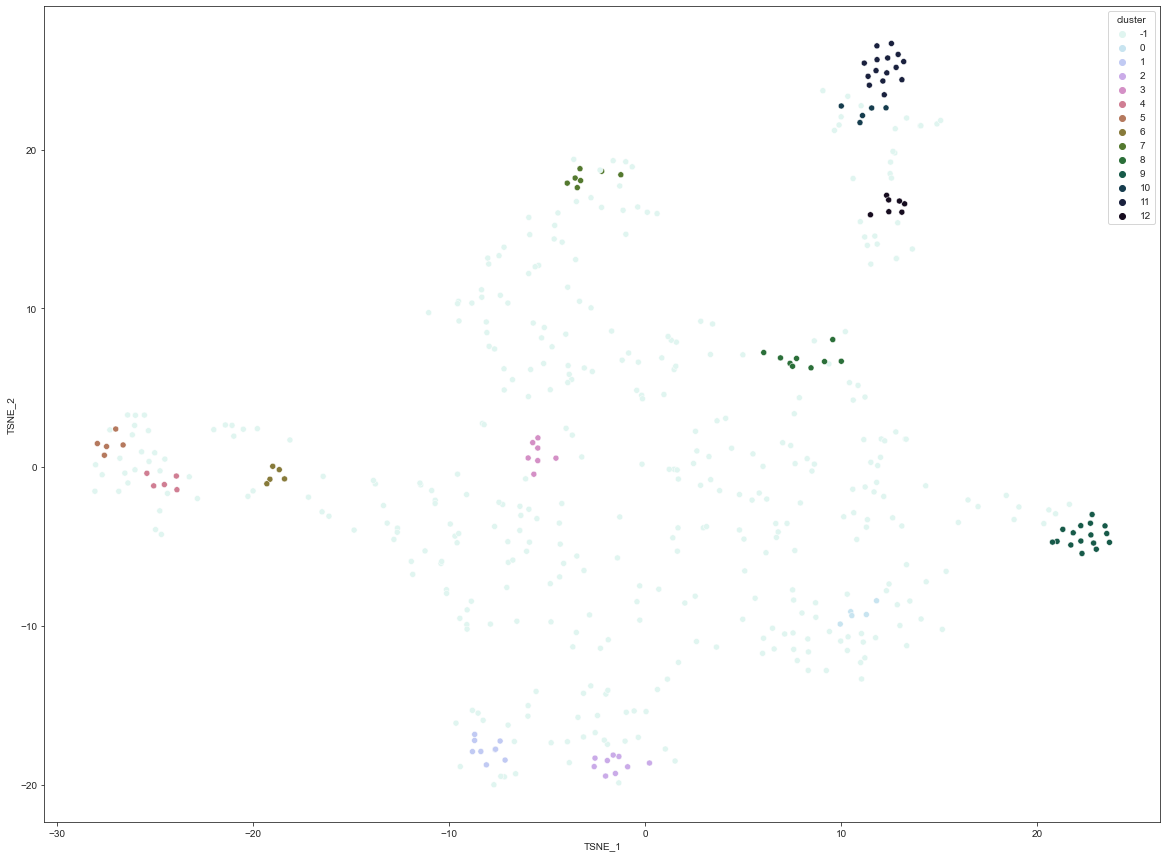

In [7]:
plt.figure(figsize=(20,15))
sns.set_style("ticks")
sns.scatterplot(
    x='TSNE_1',
    y='TSNE_2',
    data=tsne_pca_df,
    hue='cluster',
    palette="cubehelix_r"
)

## Part C: Cointegration, Hurst Exponent, Half-life and Mean Crossovers

When it comes to pair trading, cointegration test is important. Not all linear combinations of two stocks are stationary.

In this part, we will use Engle-Granger test to verify cointegration between two stocks and get the hedge ratio. This is done by the `engle_granger` function from `arch` package.

After cointegration test, we would build the spread according to the hedge ratio and then test the following:
- Hurst Exponent
- Mean Reversion Half Life
- Number of times crossing over the mean

In [8]:
pair_selector.cointegrate_filter()
pair_selector.hurst_filter()
pair_selector.hl_filter()
pair_selector.crossover_filter()

{('NSC', 'UNP'): (16, 36),
 ('LRCX', 'TER'): (23, 43),
 ('IQV', 'MCD'): (16, 39),
 ('MCD', 'SYK'): (33, 54),
 ('CB', 'RE'): (19, 43),
 ('RE', 'TRV'): (13, 23),
 ('DVN', 'NOV'): (16, 25),
 ('LNT', 'AEP'): (21, 23),
 ('LNT', 'CMS'): (19, 24),
 ('ED', 'DUK'): (17, 28),
 ('D', 'EVRG'): (13, 25),
 ('ES', 'WEC'): (18, 25),
 ('ES', 'XEL'): (21, 27),
 ('WEC', 'XEL'): (16, 25),
 ('AIV', 'EQR'): (21, 26),
 ('AIV', 'ESS'): (21, 31),
 ('EQR', 'ESS'): (19, 31),
 ('ESS', 'UDR'): (21, 32)}

In [9]:
len(pair_selector.selected_set)

18

After filtering, only 18 pairs were selected as feasible candidates for mean-reversion pair trading. From more than 127,000 pairs, we narrowed down our range into 18 pairs!

### Do these pairs make sense?

Usually, the stocks that can form a long-short trading pair share some connections. Let's see if this is the case.

In [10]:
info = pair_selector.stockinfo
for pair in pair_selector.selected_set:
    selected_one, selected_two = pair
    info_one = info[info['Symbol'] == selected_one]
    info_two = info[info['Symbol'] == selected_two]
    one_sub_industry = info_one['GICS Sub-Industry'].values[0]
    two_sub_industry = info_two['GICS Sub-Industry'].values[0]
    print('{}: {}\n{}: {}'.format(selected_one, one_sub_industry, selected_two, two_sub_industry))
    print('-'*15)

ES: Multi-Utilities
XEL: Multi-Utilities
---------------
ED: Electric Utilities
DUK: Electric Utilities
---------------
IQV: Life Sciences Tools & Services
MCD: Restaurants
---------------
D: Electric Utilities
EVRG: Electric Utilities
---------------
AIV: Residential REITs
EQR: Residential REITs
---------------
NSC: Railroads
UNP: Railroads
---------------
AIV: Residential REITs
ESS: Residential REITs
---------------
ESS: Residential REITs
UDR: Residential REITs
---------------
ES: Multi-Utilities
WEC: Electric Utilities
---------------
EQR: Residential REITs
ESS: Residential REITs
---------------
LRCX: Semiconductor Equipment
TER: Semiconductor Equipment
---------------
MCD: Restaurants
SYK: Health Care Equipment
---------------
DVN: Oil & Gas Exploration & Production
NOV: Oil & Gas Equipment & Services
---------------
LNT: Electric Utilities
CMS: Multi-Utilities
---------------
CB: Property & Casualty Insurance
RE: Reinsurance
---------------
RE: Reinsurance
TRV: Property & Casualty

The results corroborated our hypothesis: Most of the pairs belong to the same sector/industry.

### Price Action

In [37]:
def plot_price_n_spread(price1, price2, spread):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(15,10))
    ax1.plot(price1, label=price1.name)
    ax1.plot(price2, label=price2.name)
    ax1.legend(loc='upper left', fontsize=12)
    ax1.tick_params(axis='y', labelsize=14)
    ax2.plot(spread, label=spread.name)
    ax2.legend(loc='best', fontsize=12)
    ax2.axhline(y=spread.mean(), color='black')
    ax2.xaxis.set_major_locator(years)
    ax2.xaxis.set_major_formatter(yearsFmt)
    ax2.xaxis.set_minor_locator(months)
    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    ax2.set_xlim((pd.Timestamp(2016,1,1), pd.Timestamp(2020, 10, 31)))
    fig.show()

In [38]:
plot_examples = list(pair_selector.selected_set)[:5]

We would plot 5 example pairs below.

c:\users\wang4\pycharmprojects\hudson_thames\venv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


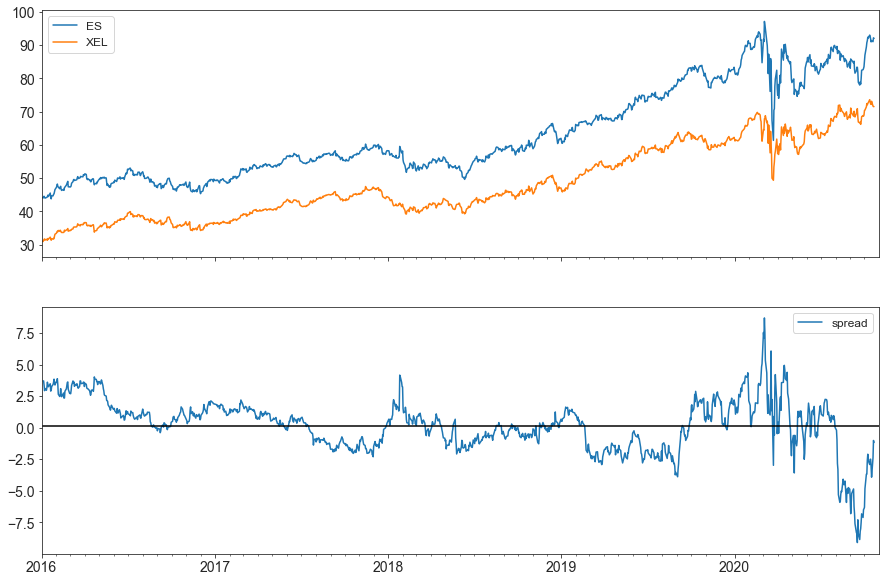

In [39]:
pair = plot_examples[0]
selected_one, selected_two = pair
price_one = pair_selector.pricedict[selected_one][selected_one]
price_two = pair_selector.pricedict[selected_two][selected_two]

spread_data = pair_selector.spreaddict[pair]['spread']
plot_price_n_spread(price_one, price_two, spread_data)

c:\users\wang4\pycharmprojects\hudson_thames\venv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


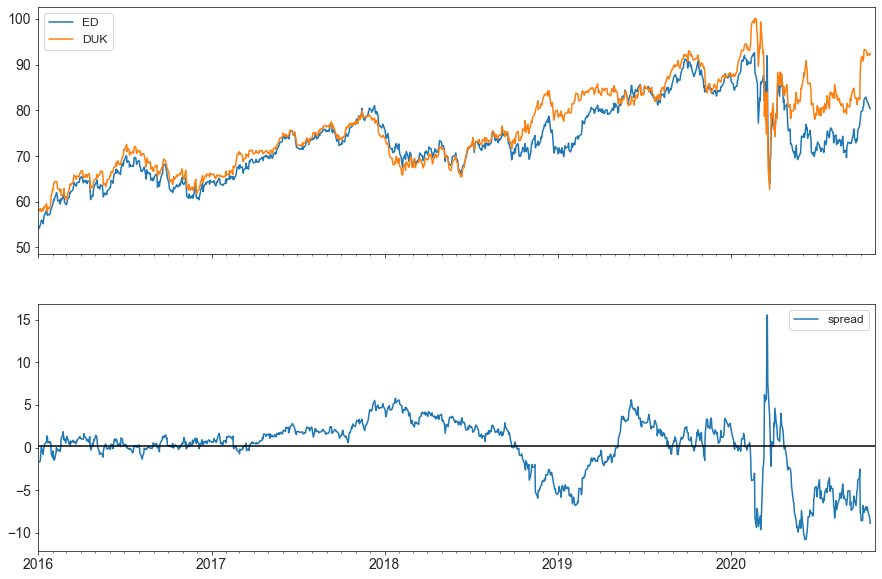

In [40]:
pair = plot_examples[1]
selected_one, selected_two = pair
price_one = pair_selector.pricedict[selected_one][selected_one]
price_two = pair_selector.pricedict[selected_two][selected_two]

spread_data = pair_selector.spreaddict[pair]['spread']
plot_price_n_spread(price_one, price_two, spread_data)

c:\users\wang4\pycharmprojects\hudson_thames\venv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


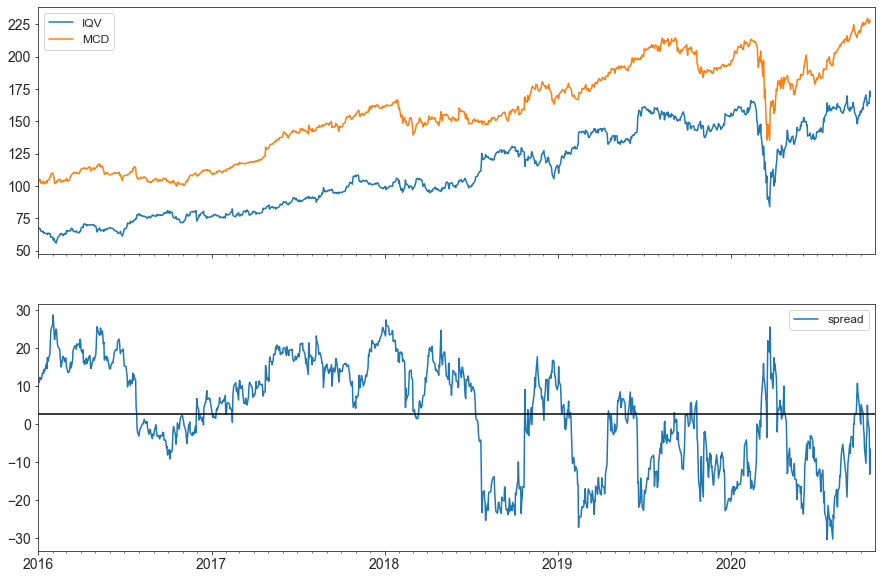

In [41]:
pair = plot_examples[2]
selected_one, selected_two = pair
price_one = pair_selector.pricedict[selected_one][selected_one]
price_two = pair_selector.pricedict[selected_two][selected_two]

spread_data = pair_selector.spreaddict[pair]['spread']
plot_price_n_spread(price_one, price_two, spread_data)

c:\users\wang4\pycharmprojects\hudson_thames\venv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


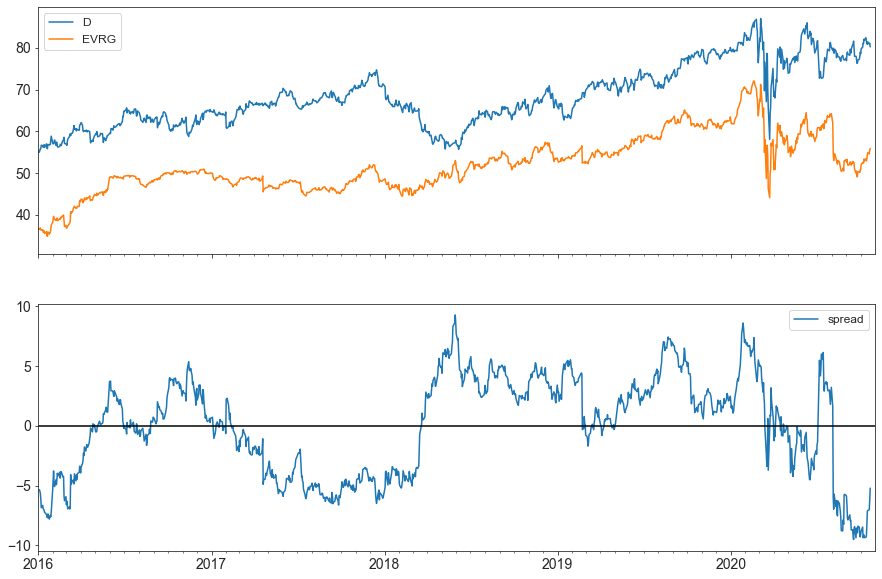

In [42]:
pair = plot_examples[3]
selected_one, selected_two = pair
price_one = pair_selector.pricedict[selected_one][selected_one]
price_two = pair_selector.pricedict[selected_two][selected_two]

spread_data = pair_selector.spreaddict[pair]['spread']
plot_price_n_spread(price_one, price_two, spread_data)

c:\users\wang4\pycharmprojects\hudson_thames\venv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


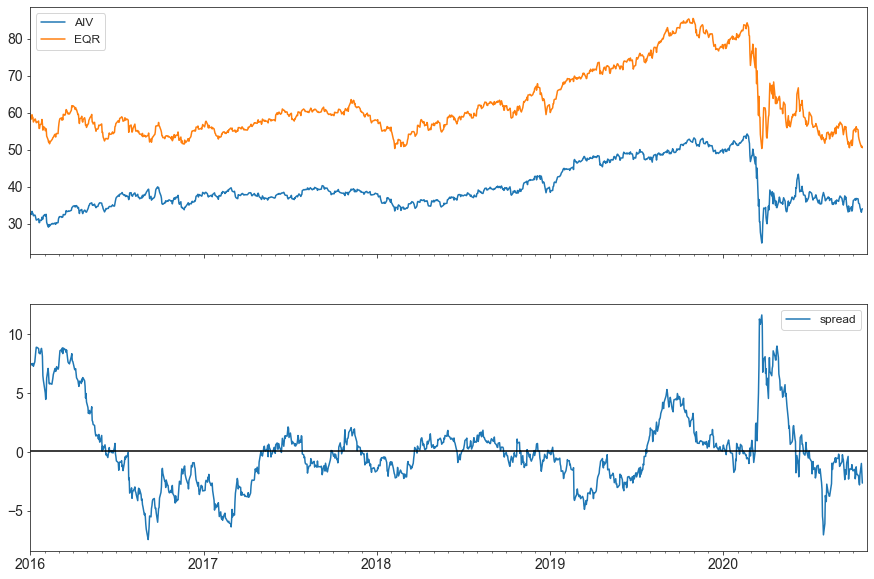

In [43]:
pair = plot_examples[4]
selected_one, selected_two = pair
price_one = pair_selector.pricedict[selected_one][selected_one]
price_two = pair_selector.pricedict[selected_two][selected_two]

spread_data = pair_selector.spreaddict[pair]['spread']
plot_price_n_spread(price_one, price_two, spread_data)